Model Mean Squared Error: 0.5822364452442839


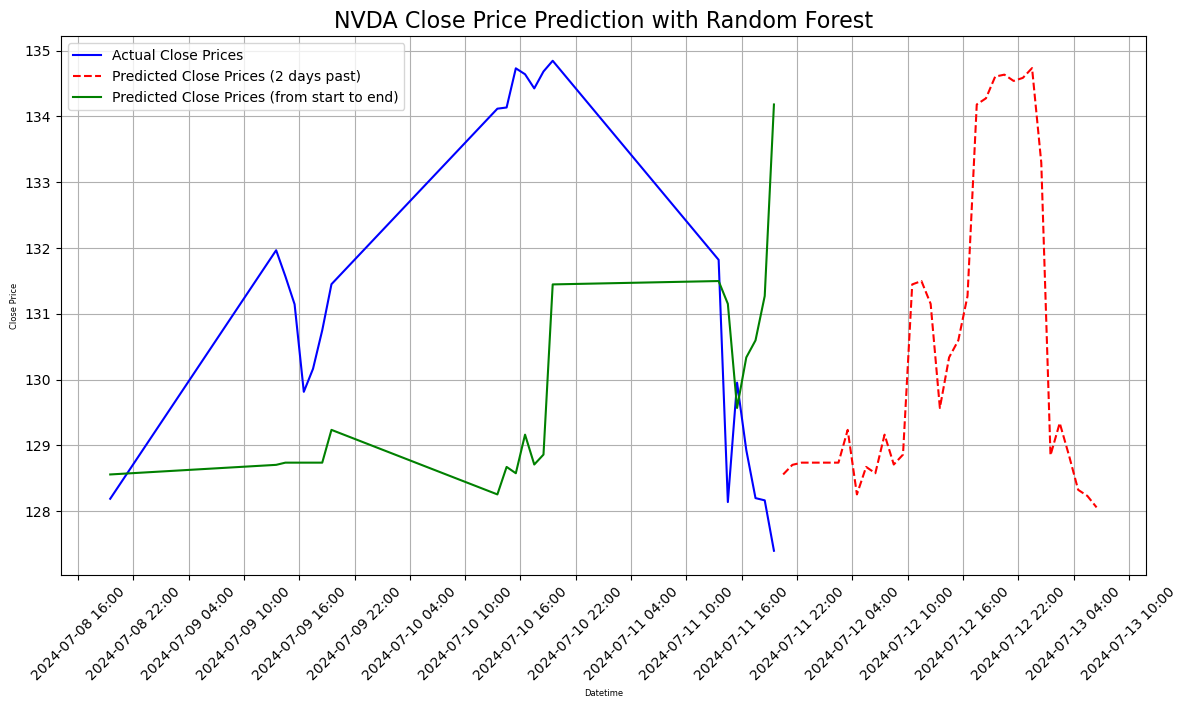

In [1]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Define URLs for trading knowledge
concepts = {
    "Income Statement": "https://ibkrcampus.com/trading-lessons/income-statement-2/", 
    "Balance Sheet": "https://blueberrymarkets.com/market-analysis/news/how-to-read-a-balance-sheet-for-trading/#:~:text=A%20balance%20sheet%20provides%20a,leverage%2C%20and%20overall%20financial%20position.", 
    "Cash Flow Statement": "https://www.investopedia.com/investing/what-is-a-cash-flow-statement/#:~:text=Also%20known%20as%20the%20statement,is%20on%20solid%20financial%20ground.", 
    "Price-to-Earnings (P/E) Ratio": "https://www.investopedia.com/investing/use-pe-ratio-and-peg-to-tell-stocks-future/#:~:text=Key%20Takeaways,is%20low%20relative%20to%20earnings.", 
    "Price-to-Book (P/B) Ratio": "https://www.investopedia.com/terms/p/price-to-bookratio.asp#:~:text=What%20Is%20the%20Price%2Dto%2DBook%20(P%2FB,value%20per%20share%20(BVPS).", 
    "Return on Equity (ROE)": "https://www.investopedia.com/terms/r/returnonequity.asp", 
    "Debt-to-Equity Ratio": "https://www.investopedia.com/terms/d/debtequityratio.asp#:~:text=%2FE)%20Ratio%3F-,The%20debt%2Dto%2Dequity%20(D%2FE)%20ratio,important%20metric%20in%20corporate%20finance.", 
    "Trends": "https://www.investopedia.com/terms/t/trendtrading.asp", 
    "Support and Resistance Levels": "https://www.investopedia.com/trading/support-and-resistance-basics/", 
    "Moving Averages": "https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp#:~:text=A%20moving%20average%20(MA)%20is,days%20for%20the%20averaging%20interval.", 
    "Stop-Loss Orders": "https://www.investopedia.com/terms/s/stop-lossorder.asp",
    "Hedging": "https://www.investopedia.com/trading/hedging-beginners-guide/"
}

# Define URLs for investing strategies
investingStrategies = {
    "Quantitative Investment Strategies": "https://www.investopedia.com/articles/trading/09/quant-strategies.asp",
    "Key Investment Strategies": "https://www.investopedia.com/investing/investing-strategies/",
    "Mid-cap Investing": "https://www.investopedia.com/mid-cap-investing-strategies-5225553",
    "Event-Driven Investing": "https://www.investopedia.com/terms/e/eventdriven.asp",
    "Immunization": "https://www.investopedia.com/terms/i/immunization.asp"
}

# Function to scrape data from URLs
def scrape_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    paragraphs = soup.find_all('p')
    text_data = ' '.join([p.get_text() for p in paragraphs])
    return text_data

# Load trading knowledge and investing strategies
def load_knowledge_data(concepts, strategies):
    knowledge_data = []
    for name, url in {**concepts, **strategies}.items():
        knowledge_data.append(scrape_data(url))
    return knowledge_data

# Fetching historical stock data
def fetch_stock_data(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="5d", interval="1h")
    hist.reset_index(inplace=True)
    hist['Datetime'] = pd.to_datetime(hist['Datetime'])
    return hist

# Preprocess the stock data
def preprocess_data(df):
    features = ['Open', 'High', 'Low', 'Volume']
    target = 'Close'
    
    imputer = SimpleImputer(strategy='mean')
    df[features] = imputer.fit_transform(df[features])
    
    scaler = MinMaxScaler()
    df[target] = scaler.fit_transform(df[[target]])
    
    return df, features, target, scaler

# Fetching news sentiment
def fetch_news_sentiment(api_key, query):
    url = f"https://newsapi.org/v2/everything?q={query}&apiKey={api_key}"
    response = requests.get(url)
    articles = response.json().get('articles', [])
    sentiments = []
    for article in articles:
        title = article.get('title') or ''
        description = article.get('description') or ''
        sentiments.append(title + " " + description)
    return ' '.join(sentiments)

# Train the regression model
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Main function to integrate all steps
def main(ticker, news_api_key):
    # Load and preprocess stock data
    hist = fetch_stock_data(ticker)
    hist, features, target, scaler = preprocess_data(hist)
    
    # Load trading knowledge and investing strategies
    knowledge_data = load_knowledge_data(concepts, investingStrategies)
    
    # Fetch news sentiment
    news_sentiment = fetch_news_sentiment(news_api_key, ticker)
    
    # Filter data for the past 3 days
    recent_data = hist[hist['Datetime'] >= (hist['Datetime'].max() - timedelta(days=3))]
    
    # Combine knowledge data and news sentiment with historical stock data
    # (This part can be expanded based on specific ways to integrate the knowledge and sentiment data into the model)
    X = recent_data[features]
    y = recent_data['Close']  # Use scaled close prices
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the regression model
    model = train_model(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Reverse the scaling on the predictions
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(scaler.inverse_transform(y_test.values.reshape(-1, 1)), predictions_rescaled)
    print(f'Model Mean Squared Error: {mse}')
    
    # This segment replaces the previous lines that fetched future_X and made predictions
    future_X = hist[features].iloc[-48:].reset_index(drop=True)  # Adjusting to fetch the last 48 rows
    future_predictions = model.predict(future_X)
    future_predictions_rescaled = scaler.inverse_transform(future_predictions.reshape(-1, 1)).flatten()

    future_dates = [recent_data['Datetime'].max() + timedelta(hours=i) for i in range(1, len(future_predictions_rescaled) + 1)]
    future_df = pd.DataFrame(future_dates, columns=['Datetime'])

# Plotting the predictions
    plt.figure(figsize=(14, 7))

# Plot actual close prices for the past 3 days
    plt.plot(recent_data['Datetime'], scaler.inverse_transform(recent_data['Close'].values.reshape(-1, 1)), label='Actual Close Prices', color='blue')

# Plot predicted close prices for the next 2 days (in red dashed line)
    plt.plot(future_df['Datetime'], future_predictions_rescaled, label='Predicted Close Prices (2 days past)', linestyle='dashed', color='red')

    # Plot predicted close prices from where actual price starts (in green solid line)
    start_to_end_dates = recent_data['Datetime']
    plt.plot(start_to_end_dates, future_predictions_rescaled[:len(start_to_end_dates)], label='Predicted Close Prices (from start to end)', linestyle='solid', color='green')


# Adding title and labels
    plt.title(f'{ticker} Close Price Prediction with Random Forest', fontsize=16)
    plt.xlabel('Datetime', fontsize=6)
    plt.ylabel('Close Price', fontsize=6)

# Formatting date axis to show hours
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate date labels for better readability
    plt.xticks(rotation=45)

# Adding grid
    plt.grid(True)

# Adding legend
    plt.legend()

# Show plot
    plt.show()

    # Save the trained model to a file
    model_filename = 'random_forest_model.joblib'
    joblib.dump(model, model_filename)

# Define the stock ticker and News API key
ticker = 'NVDA'
news_api_key = 'e08f5b17659848a3bfacc977d50a394a'

# Run the main function
main(ticker, news_api_key)


In [2]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'trader-pipeline-bucket'
model_file = 'random_forest_model.joblib'
s3.upload_file(model_file, bucket_name, model_file)